# Estimation of effective connectivity (EC) using MOU process for model
## Replication of results from the paper by [Senden et al. (2017)](#references)
This Python notebook aims to reproduce the results presented in the abovementioned paper. As the fundamental approach utilized in the paper matches exactly the one applied in a closely related project by Gilson et al. (ct. [MOUEC-Estimation notebook by Gilson et al. (2019)](#references)), the code is heavily influenced by and partly taken from this source (explicit indications are not provided in this provisional version). The class MOU (multivariate Ornstein-Uhlenbeck) from the [*pyMOU* library](#references) (pymou.mou_model), which is used in that project, was adapted to match the procedure described in the paper to be reproduced (slightly different process model). The changes exclusively effect the method fit_LO().

The files listed below are required to be positioned in the same location the main file *replicate_results_from_Senden_et_al_paper.ipynb* is located. 
- *mou_model.py* (The adapted version of the eponymous file from the [*pyMOU* library](#references).)
- *DATA_TASK_3DMOV_HP_CSF_WD.mat* (BOLD time series (funtional data) and ROI lables.)
- *BINARY_EC_MASK.mat* (Anatomical connectome averaged over subjects (structural data).)

In [1]:
## Import dependencies.
import os
import itertools
import scipy.io
import scipy.stats as stt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mou_model import MOU
%matplotlib inline

## Introduce constants.
_RES_DIR = 'model_parameter/'
_I_REST_RUN = 0
_I_NBACK_RUN = 1
_I_NO_TIMESHIFT = 0
_I_ONE_TIMESHIFT = 1
_SUBJECT_AXIS = 0

## Create a local folder to store results.
if not os.path.exists(_RES_DIR):
    print('created directory:', _RES_DIR)
    os.makedirs(_RES_DIR)

### Data set
The data set consists of 5 sessions for 14 subjects: one each for rest, the n-back task, the flanker task, the mental rotation task, and the odd-man out task. Each session is about 6 minutes long and consists of 192 time points (fMRI time resolution TR = 2 seconds). The parcellation corresponds to the Desikan-Killany (DK) atlas (Desikan et al., 2006; Klein & Tourville, 2012) with 68 regions of interest (ROIs).
The preprocessed fMRI data was downloaded from https://datadryad.org/stash/dataset/doi:10.5061/dryad.mc7pd. For more detailed information concerning the data follow the link above.

The data files are:
 - *DATA_TASK_3DMOV_HP_CSF_WD.mat* (BOLD time series (funtional data) and ROI lables)
 - *BINARY_EC_MASK.mat* (anatomical connectome averaged over subjects (structural data))

As the data format of the preprocessed data is different to the one in the aforementioned notebook by Gilson ([MOUEC-Estimation notebook by Gilson et al. (2019)](#references)), it is restructured to match the format of the latter for enhanced comparability.

In [2]:
## Read in data and structure it.
fMRI_data_and_labels = scipy.io.loadmat('BOLD_data_and_SC_matrix/DATA_TASK_3DMOV_HP_CSF_WD.mat')
regionalized_preprocessed_fMRI_data = fMRI_data_and_labels['TASKEC'][0][0]
roi_labels = fMRI_data_and_labels['ROIlbls'][0]
rest_run_data = regionalized_preprocessed_fMRI_data['Rest']
# Display the ROI labels
print('R'+'\u0332'+'egions O'+'\u0332'+'f I'+'\u0332'+'nterest (ROIs): \n')
for i,elem in enumerate(np.concatenate(roi_labels)): 
    print(f'{i:2d} : {elem}')
# The fMRI data properties.
n_subjects = rest_run_data.shape[2]
n_runs = len(fMRI_data_and_labels['TASKEC'][0][0])
n_rois = rest_run_data.shape[1]
n_ts_samples = rest_run_data.shape[0]
# Restructure data.
filtered_ts_emp = np.zeros([n_subjects, n_runs, n_rois, n_ts_samples])
run = list(regionalized_preprocessed_fMRI_data.dtype.fields.keys())
for k in range(len(run)):
    filtered_ts_emp[:, k, :, :] = np.transpose(
        regionalized_preprocessed_fMRI_data[run[k]], (2, 1, 0))

R̲egions O̲f I̲nterest (ROIs): 

 0 : lh_bankssts
 1 : lh_caudalanteriorcingulate
 2 : lh_caudalmiddlefrontal
 3 : lh_cuneus
 4 : lh_entorhinal
 5 : lh_fusiform
 6 : lh_inferiorparietal
 7 : lh_inferiortemporal
 8 : lh_isthmuscingulate
 9 : lh_lateraloccipital
10 : lh_lateralorbitofrontal
11 : lh_lingual
12 : lh_medialorbitofrontal
13 : lh_middletemporal
14 : lh_parahippocampal
15 : lh_paracentral
16 : lh_parsopercularis
17 : lh_parsorbitalis
18 : lh_parstriangularis
19 : lh_pericalcarine
20 : lh_postcentral
21 : lh_posteriorcingulate
22 : lh_precentral
23 : lh_precuneus
24 : lh_rostralanteriorcingulate
25 : lh_rostralmiddlefrontal
26 : lh_superiorfrontal
27 : lh_superiorparietal
28 : lh_superiortemporal
29 : lh_supramarginal
30 : lh_frontalpole
31 : lh_temporalpole
32 : lh_transversetemporal
33 : lh_insula
34 : rh_bankssts
35 : rh_caudalanteriorcingulate
36 : rh_caudalmiddlefrontal
37 : rh_cuneus
38 : rh_entorhinal
39 : rh_fusiform
40 : rh_inferiorparietal
41 : rh_inferiortemporal
42 

### Functional connectivity (FC)
As the BOLD covariances "are natural objective functions for the MOU model," ([MOUEC-Estimation notebook by Gilson et al. (2019)](#references)) they are used as  functional connectivity here. The BOLD time series are zero-centered in order to eliminate offset differences between runs.

In [3]:
## Calculate functional connectivity (BOLD covariances) [Q0 and Q1].
def calculate_FC(filtered_ts_emp, n_shifts):
    n_subjects, n_runs, n_rois, n_ts_samples = filtered_ts_emp.shape
    FC_emp = np.zeros([n_subjects, n_runs, n_shifts, n_rois, n_rois])
    n_ts_span = n_ts_samples - n_shifts + 1
    for i_subject in range(n_subjects):
        for i_run in range(n_runs):
            # Center the time series (around zero).
            filtered_ts_emp[i_subject, i_run, :, :] -=  \
                    np.outer(filtered_ts_emp[i_subject, i_run, :, :].
                             mean(axis=1), np.ones([n_ts_samples]))
            # Calculate covariances with various time shifts.
            for i_shift in range(n_shifts):
                for i_roi in range(n_rois):
                    FC_emp[i_subject, i_run, i_shift, :, i_roi] = \
                    np.dot(filtered_ts_emp[i_subject, i_run, :,
                                           0:n_ts_span], 
                           filtered_ts_emp[i_subject, i_run, i_roi,
                                           i_shift:n_ts_span + i_shift]
                          ) / float(n_ts_span)
    return FC_emp

Due to the application of the min-max-scaler most of the FC values should be between 0 and 1
Min FC0 value: -0.06868975988327365
Mean FC0 value: 0.16097288442340008
Max FC0 value: 1.0
Mean BOLD variance (diagonal of each FC0 matrix): 0.5393766793807483


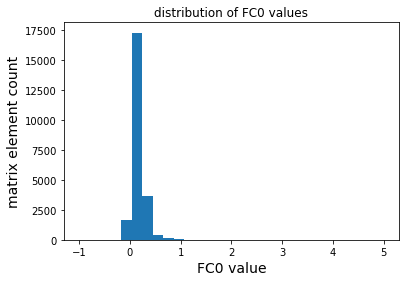

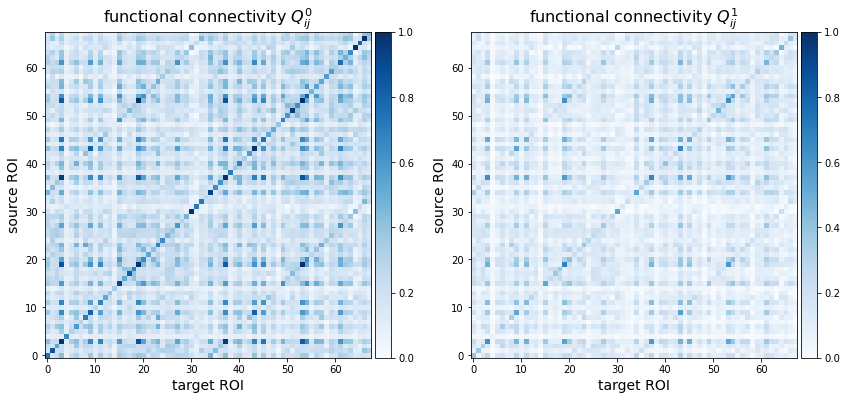

In [5]:
## Calculate functional connectivity (BOLD covariances) [Q0 and Q1].
time_shift = np.arange(2, dtype=float)
n_shifts = len(time_shift)
FC_emp = calculate_FC(filtered_ts_emp, n_shifts)

# Clip the FC at the maximum of the off-diagonal elements.
FC0_rest_subj_avg = FC_emp[
    :, _I_REST_RUN, _I_NO_TIMESHIFT, :, :].mean(axis=_SUBJECT_AXIS)
np.fill_diagonal(FC0_rest_subj_avg, 0)
upper_clipping_limit = np.max(FC0_rest_subj_avg)
FC_avg_over_subj = FC_emp[:, :, :, :, :].mean(axis=_SUBJECT_AXIS)
FC_avg_over_subj[FC_avg_over_subj > upper_clipping_limit] = upper_clipping_limit

# Scale clipped FC to the range [0, 1].
min_max_scaler = MinMaxScaler()
FC0_rest_subj_avg = np.copy(
    FC_avg_over_subj[_I_REST_RUN,_I_NO_TIMESHIFT, :, :])
FC0_rest_subj_avg_scaled = min_max_scaler.fit_transform(
    FC0_rest_subj_avg.reshape(-1, 1)).reshape(n_rois, n_rois)
FC_scaler = np.vectorize(lambda matrix_2d: min_max_scaler.transform(
    matrix_2d.reshape(-1, 1)).reshape(
    matrix_2d.shape), signature='(m,n)->(m,n)')
FC_avg_over_subj_scaled = FC_scaler(FC_avg_over_subj)


#   # Rescale as in aforementioned notebook (values not exclusively in [0, 1]):
#   rescale_FC_factor = (0.5 / FC_emp[:, _I_REST_RUN, _I_NO_TIMESHIFT, :,
#                                     :].diagonal(axis1=1, axis2=2).mean())
#   FC_emp *= rescale_FC_factor
#   # filtered_ts_emp /= np.sqrt(rescale_FC_factor)
# 
# print('Due to rescaling (rescale factor = ', rescale_FC_factor,
#       ') most of the FC values should be between 0 and 1')
print('Due to the application of the min-max-scaler most of the FC values \
should be between 0 and 1')
print('Min FC0 value:', 
      FC_avg_over_subj_scaled[:, _I_NO_TIMESHIFT, :, :].min())
print('Mean FC0 value:', 
      FC_avg_over_subj_scaled[:, _I_NO_TIMESHIFT, :, :].mean())
print('Max FC0 value:', 
      FC_avg_over_subj_scaled[:, _I_NO_TIMESHIFT, :, :].max())
# print('Min FC0 value:', FC0_rest_subj_avg_scaled.min())
# print('Max FC0 value:', FC0_rest_subj_avg_scaled.max())
print('Mean BOLD variance (diagonal of each FC0 matrix):', 
      FC_avg_over_subj_scaled[:, _I_NO_TIMESHIFT, :, :].diagonal(
          axis1=1, axis2=2).mean())
# Show distibution of FC0 values.
plt.figure()
plt.hist(FC_avg_over_subj_scaled[:, _I_NO_TIMESHIFT, :, :].flatten(),
         bins=np.linspace(-1, 5, 30))
plt.xlabel('FC0 value', fontsize=14)
plt.ylabel('matrix element count', fontsize=14)
plt.title('distribution of FC0 values')
# Show FC0 averaged over subjects for the rest run.
plt.figure(figsize=(14, 6))
plt.subplot(121)
# FC_avg_over_subj = FC_emp[:, _I_REST_RUN,
#                           _I_NO_TIMESHIFT, :, :].mean(axis=_SUBJECT_AXIS)
FC_rest = FC_avg_over_subj_scaled[_I_REST_RUN, _I_NO_TIMESHIFT, :, :]
ax = plt.gca()
im = ax.imshow(FC_rest, origin='lower', cmap='Blues', vmin=0, vmax=1)
devider = make_axes_locatable(ax)
cax = devider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_xlabel('target ROI', fontsize=14)
ax.set_ylabel('source ROI', fontsize=14)
ax.set_title('functional connectivity $Q_{ij}^0$', fontsize=16)
# Show FC1 averaged over subjects for the rest run.
plt.subplot(122)
# FC_avg_over_subj = FC_emp[:, _I_REST_RUN,
#                           _I_ONE_TIMESHIFT, :, :].mean(axis=_SUBJECT_AXIS)
FC_nBack = FC_avg_over_subj_scaled[_I_REST_RUN, _I_ONE_TIMESHIFT, :, :]
ax = plt.gca()
im = ax.imshow(FC_nBack, origin='lower', cmap='Blues', vmin=0, vmax=1)
devider = make_axes_locatable(ax)
cax = devider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_xlabel('target ROI', fontsize=14)
ax.set_ylabel('source ROI', fontsize=14)
ax.set_title('functional connectivity $Q_{ij}^1$', fontsize=16)
plt.show()

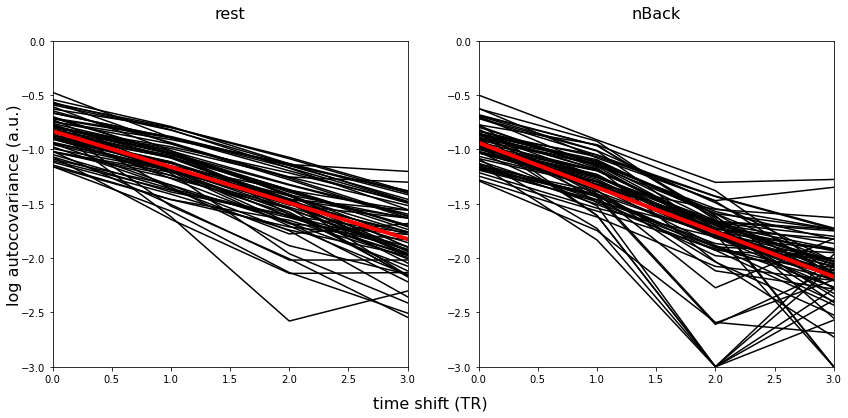

In [6]:
# Calculate the logarithm of the autocovariance.
ylim = -3
n_shifts = 4
FC_emp = calculate_FC(filtered_ts_emp, n_shifts)
ac = FC_emp[:, :, :, :, :].diagonal(axis1=3, axis2=4)
log_ac = np.log10(np.maximum(ac[:, :, :, :].mean(axis=_SUBJECT_AXIS), 
                             pow(10, ylim)))
v_tau = np.arange(ac.shape[2], dtype=np.float)
# Show the autocovariance for the rest run.
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
fig.text(0.5, 0.03, 'time shift (TR)', ha='center', fontsize=16)
fig.text(0.08, 0.5, 'log autocovariance (a.u.)', va='center', 
         rotation='vertical', fontsize=16)
plt.subplot(121)
plt.plot(range(n_shifts), log_ac[_I_REST_RUN,:,:], '-k')
lin_reg_rest = np.polyfit( np.repeat(v_tau, n_rois), 
                          log_ac[_I_REST_RUN,:,:].reshape(-1), 1 )
plt.plot(v_tau, lin_reg_rest[0]*v_tau + lin_reg_rest[1], '-r', linewidth=4)
plt.title('rest', fontsize=16, y=1.05)
plt.ylim((ylim, 0))
plt.xlim((0, n_shifts-1))
# Show the autocovariance for the nBack run.
plt.subplot(122)
plt.plot(range(n_shifts), log_ac[_I_NBACK_RUN,:,:], '-k')
lin_reg_nback = np.polyfit(np.repeat(v_tau, n_rois), 
                           log_ac[_I_NBACK_RUN,:,:].reshape(-1), 1 )
plt.plot(v_tau, lin_reg_nback[0]*v_tau + lin_reg_nback[1], '-r', linewidth=4)
plt.title('nBack', fontsize=16, y=1.05)
plt.ylim((ylim, 0))
plt.xlim((0, n_shifts-1))
plt.show()

### Structural connectivity (SC)
The SC-matrix can be found at http://dutchconnectomelab.nl/ under the title 'Group-averaged binary connectivity matrix based on 50 healthy subjects. Data as used in the paper "Edge-centric perspective on the human connectome: link communities in the brain", De Reus et al. 2014, Philosophical Transactions of the Royal Society B. Oct 5;369(1653).' in the download section. Although this matrix is not the one used in the paper, it looks like the best alternative, for the paper does not provide a reference to the original matrix.

Typically, structural connectivity indicates 'the probability or the density of white-matter projections between pairs of ROIs in the parcellation. The algorithm that fits the model to the functional data (BOLD signals) only uses the information about whether there is a connection or not between two ROIs, to decide whether the corresponding weight is optimized.' ([MOUEC-Estimation notebook by Gilson et al. (2019)](#references)) So, the downloaded binary matrix is completely sufficient for the purpose of reproducing the results from the abovementioned [Senden et al. (2017)](#references) paper.

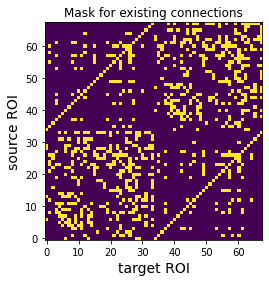

In [7]:
## Include structural connectivity.
# Load the binary structural connectivity matrix.
mask_EC = np.array(scipy.io.loadmat('BOLD_data_and_SC_matrix/BINARY_EC_MASK.mat')
                   ['grouped_umcu50_60percent'], dtype=bool)
# Enforce hermispheric connections.
for i in range(int(n_rois/2)):
    mask_EC[i, int(n_rois/2)+i] = True
    mask_EC[int(n_rois/2)+i, i] = True
# Visualise the binary structural connectivity mask.
plt.figure()
plt.imshow(mask_EC, origin='lower')
plt.xlabel('target ROI', fontsize=14)
plt.ylabel('source ROI', fontsize=14)
plt.title('Mask for existing connections', fontsize=12)
plt.show()

### MOU-EC estimation
'The optimization procedure tunes the parameters of the MOU model, namely the directional connectivity ($C$, referred to as MOU-EC) and the input covariance ($\Sigma$). It is a gradient descent that aims to minimize the matrix distance between the model and empirical covariances (referred to as spatiotemporal FC). In practice, it is encapsulated in the *fit* method of the *MOU* class. For a tutorial of the use of the MOU class for simulation and estimation, check the [*MOU_Simulation_Estimation* notebook](#references).

The optimization algorithm works with learning rates for the connectivity and the input covariance ($\epsilon_C$ and $\epsilon_\Sigma$). If they are too fast, the fitting procedure may end up being stuck in a worse local minimum than what is achievable with smaller learning rates.' ([MOUEC-Estimation notebook by Gilson et al. (2019)](#references)) In the paper (ct. [Senden et al. (2017)](#references)) $\epsilon_C = 0.001$ and $\epsilon_\Sigma = 0.1$ were chosen. For quicker but less finely graduated otimization try $\epsilon_C = 0.001$ and $\epsilon_\Sigma = 0.1$ with `mou_model.fit(filtered_ts_emp[i_sub,i_run,:,:].T, mask_C=mask_EC, mask_Sigma=mask_Sigma, epsilon_C=0.001, epsilon_Sigma=0.1)`.

All parameters/restrictions not explicitly passed to the fit@MOU method, have the correct defaults in fit_LO@MOU.

Depending on the value of $\epsilon_C$ the following cell might take about 30 minutes ($\epsilon_C = 0.0001) and more to run through.

In [23]:
## Calculate EC-matrix.
# Construct diagonal mask for input noise matrix
# (here, no input cross-correlation).
mask_Sigma = np.eye(n_rois, dtype=bool)

# # Run the model optimization.
# # Initialize the source arrays.
# # Jacobian (off-diagonal elements = EC)
# J_mod = np.zeros([n_subjects, n_runs, n_rois, n_rois])
# # Local variance (input covariance matrix, chosen to be diagonal)
# Sigma_mod = np.zeros([n_subjects, n_runs, n_rois, n_rois])
# # Model error
# dist_mod = np.zeros([n_subjects, n_runs])
# # Approximation of variance about the fitted data (FC covariance matrices)
# R2_mod = np.zeros([n_subjects, n_runs])
# # Between-region EC matrix
# C_mod = np.zeros([n_subjects, n_runs, n_rois, n_rois])
# 
# mou_model = MOU()
# 
# for i_subject in range(n_subjects):
#     for i_run in range(n_runs):
#         # Run the estimation of model parameters, for all sessions.
#         mou_model.fit(filtered_ts_emp[i_subject, i_run, :, :].T,
#                       mask_Sigma=mask_Sigma, mask_C=mask_EC)
#         # Organize the optimization results into arrays.
#         # Extract Jacobian of the model.
#         J_mod[i_subject, i_run, :, :] = mou_model.J
#         # Extract noise (auto-)covariance matrix.
#         Sigma_mod[i_subject, i_run, :, :] = mou_model.Sigma
#         # Extract the matrix distance between the empirical objective
#         # covariances and their model counterparts
#         # (normalized for each objective matrix).
#         dist_mod[i_subject, i_run] = mou_model.d_fit['distance']
#         # The squared Pearson correlation is taken as an approximation
#         # of the variance.
#         R2_mod[i_subject, i_run] = mou_model.d_fit['correlation']**2
#         # The between-region EC matrix of the model
#         C_mod[i_subject, i_run, :, :] = mou_model.get_C()
# 
#         print('sub / run:', i_subject, i_run, ';\t model error, R2:',
#               dist_mod[i_subject, i_run], R2_mod[i_subject, i_run])


# Adapt to fulfil the requirement 'Model fitting and all analyses were 
# performed using group average lag FC matrices.' from the Senden paper 
# at the end of section 2.3 'Functional MRI data'
# ----------------------------------------------------------------------------
# Run the model optimization.
# Initialize the source arrays.
# Jacobian (off-diagonal elements = EC)
J_mod = np.zeros([n_runs, n_rois, n_rois])
# Local variance (input covariance matrix, chosen to be diagonal)
Sigma_mod = np.zeros([n_runs, n_rois, n_rois])
# Model error
dist_mod = np.zeros([n_runs])
# Approximation of variance about the fitted data (FC covariance matrices)
R2_mod = np.zeros([n_runs])
# Between-region EC matrix
C_mod = np.zeros([n_runs, n_rois, n_rois])

# Calculate FC with 0 and 1 time shift
n_shifts = 2
FC_emp = np.zeros([n_subjects, n_runs, n_shifts, n_rois, n_rois])
FC_emp = calculate_FC(filtered_ts_emp, n_shifts)
FC_emp_subj_avg = FC_emp.mean(axis=_SUBJECT_AXIS)
C = np.zeros([n_rois, n_rois])
i_tau_opt = 1

mou_model = MOU(C=C) # Pass C in order to make n_nodes known to MOU().

for i_run in range(n_runs):
    # Run the estimation of model parameters, for all sessions.
    mou_model.fit_LO(FC_emp_subj_avg[i_run], i_tau_opt, mask_Sigma=mask_Sigma, 
                     mask_C=mask_EC)
    # Organize the optimization results into arrays.
    # Extract Jacobian of the model.
    J_mod[i_run, :, :] = mou_model.J
    # Extract noise (auto-)covariance matrix.
    Sigma_mod[i_run, :, :] = mou_model.Sigma
    # Extract the matrix distance between the empirical objective
    # covariances and their model counterparts
    # (normalized for each objective matrix).
    dist_mod[i_run] = mou_model.d_fit['distance']
    # The squared Pearson correlation is taken as an approximation
    # of the variance.
    R2_mod[i_run] = mou_model.d_fit['correlation']**2
    # The between-region EC matrix of the model
    C_mod[i_run, :, :] = mou_model.get_C()

    print('run:', i_run, ';\t model error, R2:',
          dist_mod[i_run], R2_mod[i_run])
# ----------------------------------------------------------------------------
# Store the results in files.
np.save(_RES_DIR + 'FC_emp.npy',
        FC_emp)  # Empirical spatiotemporal FC
np.save(_RES_DIR + 'mask_EC.npy',
        mask_EC)  # Mask of optimized connections
np.save(_RES_DIR + 'mask_Sigma.npy',
        mask_Sigma)  # Mask of optimized Sigma elements
np.save(_RES_DIR + 'Sigma_mod.npy',
        Sigma_mod)  # Estimated Sigma matrices
np.save(_RES_DIR + 'dist_mod.npy',
        dist_mod)  # Model error
np.save(_RES_DIR + 'J_mod.npy',
        J_mod)  # Estimated Jacobian, EC + inverse time const. on diag.
print('\nFinished.')

run: 0 ;	 model error, R2: 0.514184773874156 0.666964150207568
run: 1 ;	 model error, R2: 0.5118345530619174 0.6451134943368535
run: 2 ;	 model error, R2: 0.5990626986918813 0.573547773667568
run: 3 ;	 model error, R2: 0.6050837351888878 0.5797822691457457
run: 4 ;	 model error, R2: 0.49106917635519076 0.6315661599788729

Finished.


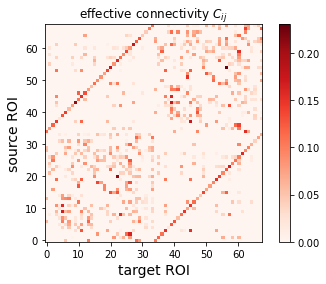

In [24]:
# # Plot C-matrix for resting state data.
# plt.figure()
# plt.imshow(C_mod[:, _I_REST_RUN, :, :].mean(axis=_SUBJECT_AXIS),
#            origin='lower', cmap='Reds')
# plt.colorbar()
# plt.xlabel('target ROI', fontsize=14)
# plt.ylabel('source ROI', fontsize=14)
# plt.title('effective connectivity $C_{ij}$')
# plt.show()


# Adapt to fulfil the requirement 'Model fitting and all analyses were 
# performed using group average lag FC matrices.' from the Senden paper 
# at the end of section 2.3 'Functional MRI data'
# ----------------------------------------------------------------------------
# Plot C-matrix for resting state data.
plt.figure()
plt.imshow(C_mod[_I_REST_RUN, :, :], origin='lower', cmap='Reds')
plt.colorbar()
plt.xlabel('target ROI', fontsize=14)
plt.ylabel('source ROI', fontsize=14)
plt.title('effective connectivity $C_{ij}$')
plt.show()

### Local variability
As in the paper, local variability ($\Sigma$) is split up into the part exhibited by the rich club and the one exhibited by the peripheral regions.

In [25]:
# ## Calculate local variability for rich club and periphery.
# # Create a 1D-mask for rich club regions.
# mask_rc = np.zeros(n_rois, dtype=bool)
# indexes_rich_club = [23, 26, 27, 57, 60, 61]
# mask_rc[indexes_rich_club] = True
# print('Rich club regions:\n',
#       np.concatenate(roi_labels[indexes_rich_club]).tolist())
# 
# local_var = Sigma_mod[:, :, :, :].diagonal(axis1=2, axis2=3)
# rc_var = local_var[:, :, mask_rc].mean(axis=0) # avarage over subjects
# periph_var = local_var[:, :, ~mask_rc].mean(axis=0) # avarage over subjects
# mean_rc_var = rc_var.mean(axis=1) # avarage over regions
# mean_periph_var = periph_var.mean(axis=1) # avarage over regions
# conf_int_rc = np.array(stt.t.interval(
#     0.95, rc_var.shape[1]-1, loc=rc_var.mean(axis=1), 
#     scale=stt.sem(rc_var, axis=1))).T
# conf_int_periph = np.array(stt.t.interval(
#     0.95, periph_var.shape[1]-1, loc=periph_var.mean(axis=1), 
#     scale=stt.sem(periph_var, axis=1))).T
# print('Mean of local variability (rich club):\n', str(mean_rc_var))
# print('Mean of local variability (periphery):\n', str(mean_periph_var))
# print('95% confidence interval (rich club):\n', conf_int_rc)
# print('95% confidence interval (periphery):\n', conf_int_periph)


# Adapt to fulfil the requirement 'Model fitting and all analyses were 
# performed using group average lag FC matrices.' from the Senden paper 
# at the end of section 2.3 'Functional MRI data'
# ----------------------------------------------------------------------------
## Calculate local variability for rich club and periphery.
# Create a 1D-mask for rich club regions.
mask_rc = np.zeros(n_rois, dtype=bool)
indexes_rich_club = [23, 26, 27, 57, 60, 61]
mask_rc[indexes_rich_club] = True
print('Rich club regions:\n',
      np.concatenate(roi_labels[indexes_rich_club]).tolist())

local_var = Sigma_mod[:, :, :].diagonal(axis1=1, axis2=2)
rc_var = local_var[:, mask_rc]
periph_var = local_var[:, ~mask_rc]
mean_rc_var = rc_var.mean(axis=1) # avarage over regions
mean_periph_var = periph_var.mean(axis=1) # avarage over regions
conf_int_rc = np.array(stt.t.interval(
    0.95, rc_var.shape[1]-1, loc=rc_var.mean(axis=1), 
    scale=stt.sem(rc_var, axis=1))).T
conf_int_periph = np.array(stt.t.interval(
    0.95, periph_var.shape[1]-1, loc=periph_var.mean(axis=1), 
    scale=stt.sem(periph_var, axis=1))).T
print('Mean of local variability (rich club):\n', str(mean_rc_var))
print('Mean of local variability (periphery):\n', str(mean_periph_var))
print('95% confidence interval (rich club):\n', conf_int_rc)
print('95% confidence interval (periphery):\n', conf_int_periph)

Rich club regions:
 ['lh_precuneus', 'lh_superiorfrontal', 'lh_superiorparietal', 'rh_precuneus', 'rh_superiorfrontal', 'rh_superiorparietal']
Mean of local variability (rich club):
 [0.02942304 0.0275558  0.0297128  0.03391961 0.03341322]
Mean of local variability (periphery):
 [0.11300901 0.11333569 0.12156284 0.12860367 0.12226918]
95% confidence interval (rich club):
 [[0.0131077  0.04573839]
 [0.0165708  0.0385408 ]
 [0.01168468 0.04774092]
 [0.01974499 0.04809423]
 [0.01741861 0.04940784]]
95% confidence interval (periphery):
 [[0.09442328 0.13159473]
 [0.09277898 0.13389239]
 [0.10094375 0.14218192]
 [0.10680512 0.15040221]
 [0.10031332 0.14422505]]


### Input-output ratio
The information flow between regions is encapsulated in the $C$-matrix. In order to test the hypotheses that the rich club might gate the input it receives from peripheral regions, the inter-rich-club-connections are ignored. This means that only the information flow from and to the rich club is examined when it comes to the inspection of the rich club input-output-ratio.

The input-output ratio of the periphery takes into account all inter-periphery activity (exclusively).

In [26]:
# ## Calculate the input-to-output ratio of total incoming/outgoing EC.
# # Create a 2D-mask for inter rich club connections.
# mask_inter_rc = np.zeros([n_rois, n_rois], dtype=bool)
# rc_ind_combin = np.array(list(
#     itertools.product(indexes_rich_club, repeat=2))).T
# mask_inter_rc[rc_ind_combin[0], rc_ind_combin[1]] = True
# # Calculate the ratio of incoming/outgoing EC from and to the rich club
# no_rc_connections_C = np.copy(C_mod)
# no_rc_connections_C[:, :, mask_inter_rc] = 0
# roi_input = no_rc_connections_C[:, :, :, :].sum(axis=2)
# roi_output = no_rc_connections_C[:, :, :, :].sum(axis=3)
# io_rc = (roi_input[:, :, mask_rc].mean(axis=0) /
#          roi_output[:, :, mask_rc].mean(axis=0))
# # Calculate and print the mean io-ratio and the CI for rich club regions
# mean_rc_io = io_rc[:, :].mean(axis=1)
# conf_int_rc = np.array(stt.t.interval(
#     0.95, io_rc.shape[1]-1, loc=io_rc.mean(axis=1), 
#     scale=stt.sem(io_rc, axis=1))).T
# print('Mean input-to-output ratio of the rich club:\n', str(mean_rc_io))
# print('95% confidence interval (rich club):\n', str(conf_int_rc))
# 
# # Create a 2D-mask for inter periphery connections.
# mask_inter_periph = np.zeros([n_rois, n_rois], dtype=bool)
# periph_ind_combin = np.array(list(itertools.product(list(
#     x for x in range(68) if x not in indexes_rich_club), repeat=2))).T
# mask_inter_periph[periph_ind_combin[0], periph_ind_combin[1]] = True
# # Calculate the ratio of incoming/outgoing EC among peripheral regions 
# only_periph_connections_C = np.copy(C_mod)
# only_periph_connections_C[:, :, ~mask_inter_periph] = 0
# roi_input = only_periph_connections_C[:, :, :, :].sum(axis=2)
# roi_output = only_periph_connections_C[:, :, :, :].sum(axis=3)
# io_periph = (roi_input[:, :, ~mask_rc].mean(axis=0) /
#          roi_output[:, :, ~mask_rc].mean(axis=0))
# # Calculate and print the mean io-ratio and the CI for peripheral regions
# mean_periph_io = io_periph[:, :].mean(axis=1)
# conf_int_periph = np.array(stt.t.interval(
#     0.95, io_periph.shape[1]-1, loc=io_periph.mean(axis=1), 
#     scale=stt.sem(io_periph, axis=1))).T
# print('Mean input-to-output ratio of the priphery:\n', str(mean_periph_io))
# print('95% confidence interval (priphery):\n', str(conf_int_periph))


# Adapt to fulfil the requirement 'Model fitting and all analyses were 
# performed using group average lag FC matrices.' from the Senden paper 
# at the end of section 2.3 'Functional MRI data'
# ----------------------------------------------------------------------------
## Calculate the input-to-output ratio of total incoming/outgoing EC.
# Create a 2D-mask for inter rich club connections.
mask_inter_rc = np.zeros([n_rois, n_rois], dtype=bool)
rc_ind_combin = np.array(list(
    itertools.product(indexes_rich_club, repeat=2))).T
mask_inter_rc[rc_ind_combin[0], rc_ind_combin[1]] = True
# Calculate the ratio of incoming/outgoing EC from and to the rich club
no_rc_connections_C = np.copy(C_mod)
no_rc_connections_C[:, mask_inter_rc] = 0
roi_input = no_rc_connections_C[:, :, :].sum(axis=1)
roi_output = no_rc_connections_C[:, :, :].sum(axis=2)
io_rc = (roi_input[:, mask_rc] /
         roi_output[:, mask_rc])
# Calculate and print the mean io-ratio and the CI for rich club regions
mean_rc_io = io_rc[:, :].mean(axis=1)
conf_int_rc = np.array(stt.t.interval(
    0.95, io_rc.shape[1]-1, loc=io_rc.mean(axis=1), 
    scale=stt.sem(io_rc, axis=1))).T
print('Mean input-to-output ratio of the rich club:\n', str(mean_rc_io))
print('95% confidence interval (rich club):\n', str(conf_int_rc))

# Create a 2D-mask for inter periphery connections.
mask_inter_periph = np.zeros([n_rois, n_rois], dtype=bool)
periph_ind_combin = np.array(list(itertools.product(list(
    x for x in range(68) if x not in indexes_rich_club), repeat=2))).T
mask_inter_periph[periph_ind_combin[0], periph_ind_combin[1]] = True
# Calculate the ratio of incoming/outgoing EC among peripheral regions 
only_periph_connections_C = np.copy(C_mod)
only_periph_connections_C[:, ~mask_inter_periph] = 0
roi_input = only_periph_connections_C[:, :, :].sum(axis=1)
roi_output = only_periph_connections_C[:, :, :].sum(axis=2)
io_periph = (roi_input[:, ~mask_rc] /
         roi_output[:, ~mask_rc])
# Calculate and print the mean io-ratio and the CI for peripheral regions
mean_periph_io = io_periph[:, :].mean(axis=1)
conf_int_periph = np.array(stt.t.interval(
    0.95, io_periph.shape[1]-1, loc=io_periph.mean(axis=1), 
    scale=stt.sem(io_periph, axis=1))).T
print('Mean input-to-output ratio of the priphery:\n', str(mean_periph_io))
print('95% confidence interval (priphery):\n', str(conf_int_periph))

# plt.figure()
# plt.imshow(mask_inter_rc, origin='lower')
# plt.xlabel('target ROI', fontsize=14)
# plt.ylabel('source ROI', fontsize=14)
# plt.title('Mask for inter rc connections', fontsize=12)
# plt.show()
# 
# plt.figure()
# plt.imshow(mask_inter_periph, origin='lower')
# plt.xlabel('target ROI', fontsize=14)
# plt.ylabel('source ROI', fontsize=14)
# plt.title('Mask for inter periphery connections', fontsize=12)
# plt.show()

Mean input-to-output ratio of the rich club:
 [0.98478486 1.34721048 1.23310959 1.355596   1.2978103 ]
95% confidence interval (rich club):
 [[0.33220761 1.63736211]
 [0.53637333 2.15804764]
 [0.33953689 2.12668229]
 [0.61195847 2.09923352]
 [0.49805805 2.09756254]]
Mean input-to-output ratio of the priphery:
 [1.00389622 1.01996227 1.00994007 1.01706108 1.00622062]
95% confidence interval (priphery):
 [[0.91331199 1.09448046]
 [0.91131899 1.12860555]
 [0.91331966 1.10656048]
 [0.91235947 1.1217627 ]
 [0.90433768 1.10810356]]


### References
<a id='references'></a>
MOUEC-Estimation notebook by Gilson et al. (2019): Andrea Insabato, Gorka Zamora-López, Matthieu Gilson 1_MOUEC_Estimation.ipynb. 2019. https://github.com/mb-BCA/notebooks_review2019/blob/master/1_MOUEC_Estimation.ipynb

*MOU_Simulation_Estimation* notebook: Andrea Insabato, Gorka Zamora-López, Matthieu Gilson MOU_Simulation_Estimation.ipynb. 2019. https://github.com/mb-BCA/pyMOU/blob/master/examples/MOU_Simulation_Estimation.ipynb

*pyMOU* library: Andrea Insabato, Gorka Zamora-López, Matthieu Gilson. 2019. https://github.com/mb-BCA/pyMOU 

Senden et al. (2017): M. Senden, N. Reuter, M. P. van den Heuvel, R. Goebel, G. Deco, and M. Gilson. Task-related effective connectivity reveals that the cortical rich club gates cortex-wide communication. Hum Brain Mapp, 2017. https://onlinelibrary.wiley.com/doi/full/10.1002/hbm.23913